In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
rates = ("usd", "jpy")

In [3]:
rates[0].upper()

'USD'

In [4]:
rates_df = pd.read_csv(f"../data/{rates[0]}_{rates[1]}_30m_20_24.csv", )

In [5]:
calendar = pd.read_csv("../data/calendar-event-list_usd_jpy.csv")

In [6]:
calendar = calendar[calendar["Impact"].isin(["LOW", "MEDIUM", "HIGH"])]
calendar = calendar[calendar["Currency"].isin([rate.upper() for rate in rates])]
calendar = calendar.reset_index()

In [7]:
rates_df["Gmt time"] = pd.to_datetime(rates_df["Gmt time"], utc=True)
calendar['Start'] = pd.to_datetime(calendar['Start'], utc=True)

In [8]:
rates_df

,Unnamed: 0,Open,High,Low,Close,Volume,US time,Gmt time,week_num
0,0,108.711,108.714,108.711,108.714,3,2020-01-02 01:30:00-05:00,2020-01-02 06:30:00+00:00,0
1,1,108.714,108.781,108.692,108.774,4171,2020-01-02 02:00:00-05:00,2020-01-02 07:00:00+00:00,0
2,2,108.775,108.800,108.773,108.785,3018,2020-01-02 02:30:00-05:00,2020-01-02 07:30:00+00:00,0
3,3,108.785,108.820,108.765,108.805,5083,2020-01-02 03:00:00-05:00,2020-01-02 08:00:00+00:00,0
4,4,108.806,108.811,108.777,108.780,4458,2020-01-02 03:30:00-05:00,2020-01-02 08:30:00+00:00,0
...,...,...,...,...,...,...,...,...,...
62228,62229,157.367,157.392,157.323,157.332,6626,2024-12-31 13:00:00-05:00,2024-12-31 18:00:00+00:00,261
62229,62230,157.332,157.357,157.235,157.296,5238,2024-12-31 13:30:00-05:00,2024-12-31 18:30:00+00:00,261
62230,62231,157.296,157.310,157.233,157.257,4974,2024-12-31 14:00:00-05:00,2024-12-31 19:00:00+00:00,261
62231,62232,157.256,157.312,157.242,157.309,4705,2024-12-31 14:30:00-05:00,2024-12-31 19:30:00+00:00,261


In [10]:
calendar[calendar["Currency"] == "JPY"]

,index,Id,Start,Name,Impact,Currency
18,18,defd5f9d-7240-4c1e-892b-35a444d2ab49,2020-01-06 00:30:00+00:00,Jibun Bank Manufacturing PMI,LOW,JPY
23,23,1278d789-321a-40cb-b65e-8540940edc00,2020-01-06 20:30:00+00:00,CFTC JPY NC Net Positions,LOW,JPY
27,27,9932cfea-70c5-4f5e-b386-56b5cbbab17f,2020-01-06 23:50:00+00:00,Monetary Base (YoY),LOW,JPY
28,28,3916ccb4-a3fd-4aec-84f9-445ff6b8b4e5,2020-01-07 00:30:00+00:00,Jibun Bank Services PMI,LOW,JPY
29,29,d40cbea8-17fa-4435-8f66-e4e2027e1a7e,2020-01-07 03:35:00+00:00,10-y Bond Auction,LOW,JPY
...,...,...,...,...,...,...
16757,16757,6764b5c2-2f9d-4c95-8cbd-aaae4d9192e5,2024-12-26 23:50:00+00:00,Large Retailer Sales,MEDIUM,JPY
16758,16758,688c4716-248a-408b-9521-94551010cc04,2024-12-26 23:50:00+00:00,Retail Trade (YoY),MEDIUM,JPY
16759,16759,435f27c8-16f6-48ba-8df4-10728d6d6f7b,2024-12-26 23:50:00+00:00,Retail Trade s.a (MoM),MEDIUM,JPY
16765,16765,0b5a05a6-3add-4c46-86cf-08c148ef343b,2024-12-30 00:30:00+00:00,Jibun Bank Manufacturing PMI,LOW,JPY


In [11]:
calendar_idx = 0
events_incoming = []
fomc = []
for rates_df_idx, row in rates_df.iterrows():

    cur_event = {}
    cur_time = row["Gmt time"]
    is_fomc = False
    
    # next timepoint in dataset
    if rates_df_idx < len(rates_df)-1:
        next_time = rates_df.loc[rates_df_idx+1, "Gmt time"]
    else:
        next_time = cur_time + pd.Timedelta(minutes=30)


    # moves to events happening between this time interval
    while calendar_idx < len(calendar) and calendar.loc[calendar_idx, "Start"] < cur_time:
        calendar_idx += 1

    
    while calendar_idx < len(calendar) and calendar.loc[calendar_idx, "Start"] < next_time:
        cur_event[f'{calendar.loc[calendar_idx, "Impact"]}-{calendar.loc[calendar_idx, "Currency"]}'] = 1
        if calendar.loc[calendar_idx, "Name"] == "FOMC Press Conference":
            is_fomc = True
        calendar_idx += 1
    events_incoming.append(cur_event)
    fomc.append(is_fomc)

In [12]:
for currency in rates:
    currency = currency.upper()
    for impact in ["LOW", "MEDIUM", "HIGH"]:
        event_exist = []
        for event in events_incoming:
            event_exist.append(int(f"{impact}-{currency}" in event))
        rates_df[f"{impact}-{currency}"] = event_exist

In [13]:
rates_df["vola"] = np.log(rates_df["High"] / rates_df["Low"])

In [14]:
rates_df[rates_df["HIGH-USD"] == 1]["vola"].mean()

0.0029254134680277858

In [15]:
rates_df[rates_df["HIGH-USD"] == 0]["vola"].mean()

0.001003214242362157

In [16]:
rates_df[rates_df["LOW-USD"] == 1]["vola"].mean()

0.0013976381314551934

In [17]:
rates_df[rates_df["HIGH-JPY"] == 1]["vola"].mean()

0.0018863778003382291

In [18]:
rates_df[rates_df["HIGH-JPY"] == 0]["vola"].mean()

0.0010264364531600715

### Interday volatility

In [19]:
def get_timepoint_index(timepoint):
    assert((timepoint.hour * 60 + timepoint.minute) % 30 == 0)
    return (timepoint.hour * 60 + timepoint.minute) // 30

def get_timepoint(timepoint_index):
    mins = timepoint_index * 30

    h = mins // 60
    m = mins - h * 60
    return h, m

In [20]:
n_timepoints = 48
lbs = 5
volas = [[] for _ in range(n_timepoints)]
prev_volas = [[] for _ in range(lbs)]
for _, row in rates_df.iterrows():
    tp_idx = get_timepoint_index(row["Gmt time"])
    for lb in range(1, lbs+1):
        if len(volas[tp_idx]) >= lb:
            prev_volas[lb-1].append(volas[tp_idx][-lb])
        else:
            prev_volas[lb-1].append(None)
        
    
    volas[tp_idx].append(row["vola"])

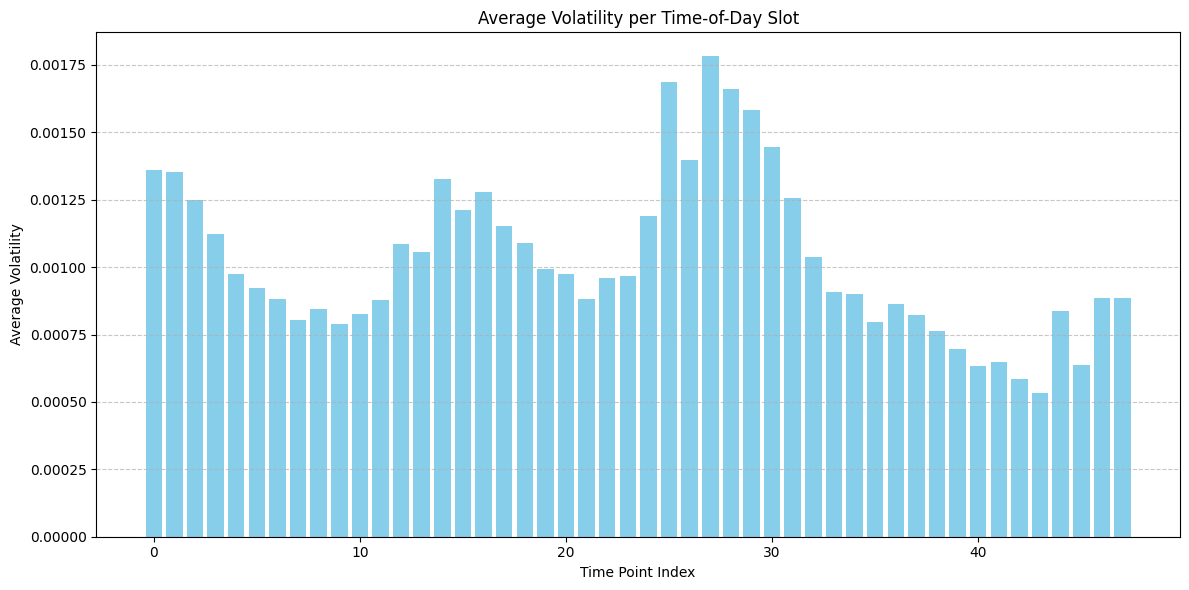

In [21]:
avg_vol = [np.mean(x) for x in volas]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(avg_vol)), avg_vol, color='skyblue')
plt.xlabel("Time Point Index")
plt.ylabel("Average Volatility")
plt.title("Average Volatility per Time-of-Day Slot")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
for lb in range(1, lbs+1):
    rates_df[f"prev_vola-{lb}"] = prev_volas[lb-1]

In [23]:
rates_df

,Unnamed: 0,Open,High,Low,Close,Volume,US time,Gmt time,week_num,LOW-USD,...,HIGH-USD,LOW-JPY,MEDIUM-JPY,HIGH-JPY,vola,prev_vola-1,prev_vola-2,prev_vola-3,prev_vola-4,prev_vola-5
0,0,108.711,108.714,108.711,108.714,3,2020-01-02 01:30:00-05:00,2020-01-02 06:30:00+00:00,0,0,...,0,0,0,0,0.000028,NaN,NaN,NaN,NaN,NaN
1,1,108.714,108.781,108.692,108.774,4171,2020-01-02 02:00:00-05:00,2020-01-02 07:00:00+00:00,0,0,...,0,0,0,0,0.000818,NaN,NaN,NaN,NaN,NaN
2,2,108.775,108.800,108.773,108.785,3018,2020-01-02 02:30:00-05:00,2020-01-02 07:30:00+00:00,0,0,...,0,0,0,0,0.000248,NaN,NaN,NaN,NaN,NaN
3,3,108.785,108.820,108.765,108.805,5083,2020-01-02 03:00:00-05:00,2020-01-02 08:00:00+00:00,0,0,...,0,0,0,0,0.000506,NaN,NaN,NaN,NaN,NaN
4,4,108.806,108.811,108.777,108.780,4458,2020-01-02 03:30:00-05:00,2020-01-02 08:30:00+00:00,0,0,...,0,0,0,0,0.000313,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62228,62229,157.367,157.392,157.323,157.332,6626,2024-12-31 13:00:00-05:00,2024-12-31 18:00:00+00:00,261,0,...,0,0,0,0,0.000438,0.000700,0.000488,0.001298,0.000445,0.000471
62229,62230,157.332,157.357,157.235,157.296,5238,2024-12-31 13:30:00-05:00,2024-12-31 18:30:00+00:00,261,0,...,0,0,0,0,0.000776,0.001019,0.000551,0.000519,0.000750,0.000592
62230,62231,157.296,157.310,157.233,157.257,4974,2024-12-31 14:00:00-05:00,2024-12-31 19:00:00+00:00,261,0,...,0,0,0,0,0.000490,0.000561,0.000462,0.000405,0.000248,0.000344
62231,62232,157.256,157.312,157.242,157.309,4705,2024-12-31 14:30:00-05:00,2024-12-31 19:30:00+00:00,261,0,...,0,0,0,0,0.000445,0.000777,0.000500,0.000690,0.000471,0.000840


In [24]:
rates_df.to_csv(f"../data/{rates[0]}_{rates[1]}_30m_20_24_ext_v1.csv")